# Multi-Class Sentiment Recognition for Twitter Tweets using HuggingFace Transformers

In [ ]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")


In [2]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


text          0
label         0
label_name    0
dtype: int64

In [3]:
df['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

## Dataset Analysis

In [4]:
import matplotlib.pyplot as plt

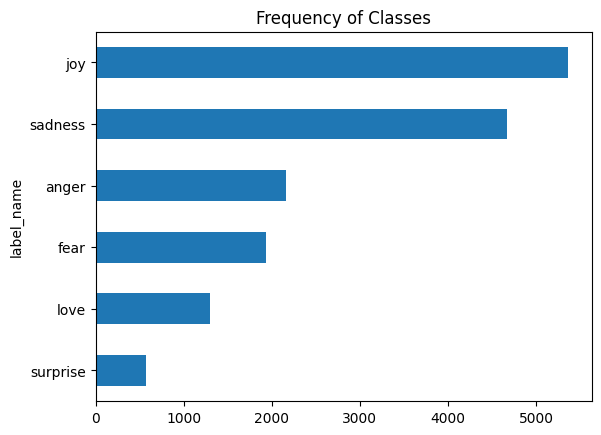

In [5]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

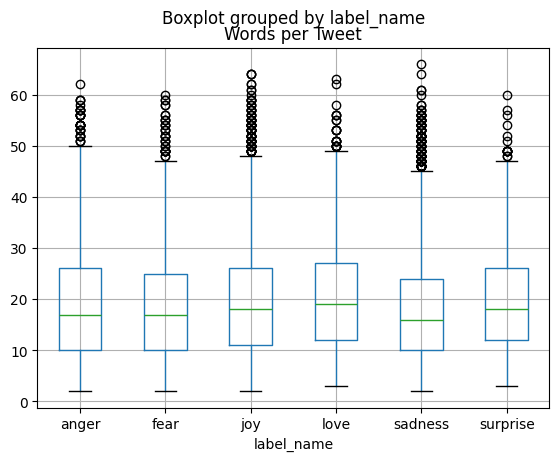

In [6]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name")

## Text to token

In [7]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

c:\envs\langchain-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [8]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [10]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
     
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion/Sentiment Data

In [11]:
dataset['train'][0], dataset['train'][1]

({'text': 'i then immediately have feelings of guilt for having those selfish thoughts and my practical side appears how could i do that who would take care of the kids and my parents',
  'label': 3,
  'label_name': 'anger',
  'Words per Tweet': 32},
 {'text': 'i think i like how it feels more lively in the dorama',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 12})

In [12]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2059, 3202, 2031, 5346, 1997, 8056, 2005, 2383, 2216, 14337, 4301, 1998, 2026, 6742, 2217, 3544, 2129, 2071, 1045, 2079, 2008, 2040, 2052, 2202, 2729, 1997, 1996, 4268, 1998, 2026, 3008, 102], [101, 1045, 2228, 1045, 2066, 2129, 2009, 5683, 2062, 17133, 1999, 1996, 21008, 2863, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [13]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1600/1600 [00:00<00:00, 8095.79 examples/s]


In [14]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'anger': 3, 'joy': 1, 'sadness': 0, 'surprise': 5, 'love': 2, 'fear': 4},
 {3: 'anger', 1: 'joy', 0: 'sadness', 5: 'surprise', 2: 'love', 4: 'fear'})

## Model Building

In [15]:
from transformers import AutoModel 
import torch

In [16]:
model = AutoModel.from_pretrained(model_ckpt)

In [17]:
model.config.id2label
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [18]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [20]:
from transformers import TrainingArguments

batch_size = 8  # small batch for speed
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=1,                      # only 1 epoch
    learning_rate=5e-5,                      # faster convergence
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.0,                        # no regularization               
    save_strategy='no',                     # don't save checkpoints
    logging_steps=10,                       # minimal logging
    disable_tqdm=True,                      # reduce overhead
    dataloader_num_workers=0,               # avoid overhead
)


In [21]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}


## Build Model and Trainer

In [23]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer)

C:\Users\Vekash s\AppData\Local\Temp\ipykernel_23732\1591179924.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [ ]:
trainer.train()

c:\envs\langchain-env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 1.73, 'grad_norm': 12.655095100402832, 'learning_rate': 4.967857142857143e-05, 'epoch': 0.007142857142857143}
{'loss': 1.636, 'grad_norm': 8.176471710205078, 'learning_rate': 4.9321428571428574e-05, 'epoch': 0.014285714285714285}
{'loss': 1.4873, 'grad_norm': 3.840484619140625, 'learning_rate': 4.896428571428572e-05, 'epoch': 0.02142857142857143}
{'loss': 1.6374, 'grad_norm': 6.342517375946045, 'learning_rate': 4.860714285714286e-05, 'epoch': 0.02857142857142857}
{'loss': 1.4476, 'grad_norm': 4.486337184906006, 'learning_rate': 4.825e-05, 'epoch': 0.03571428571428571}
{'loss': 1.5053, 'grad_norm': 9.308424949645996, 'learning_rate': 4.789285714285715e-05, 'epoch': 0.04285714285714286}
{'loss': 1.41, 'grad_norm': 8.791131973266602, 'learning_rate': 4.753571428571429e-05, 'epoch': 0.05}
{'loss': 1.248, 'grad_norm': 15.253924369812012, 'learning_rate': 4.7178571428571434e-05, 'epoch': 0.05714285714285714}
{'loss': 1.1804, 'grad_norm': 7.11994743347168, 'learning_rate': 4.68214285

In [ ]:
## Model Evaluation

In [ ]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metr

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
label2id

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Build Prediction Function and Store Model

In [ ]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

In [ ]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [ ]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])